# Logistic regression for default (proof of concept)<a class="anchor" id="top"></a>
Mykhaylo Salnykov <br>
v. 1.4<br>
Created: 11-10-2019<br>
Last modified: 14-08-2020<br>
<br>
This code is designed to establish business case on using predictive analytics' logistic regression machine learning tool to predict defaults.<br>
<br>
This code demonstrates tradeoff between default recall (being able to correctly identify true defaults) and nondefault recall (being able to identify true nondefaults) in logistic regression models by changing threshold value (i.e. a the highest acceptable predicted probability of default. <br>
<br>
The case shows that an un-tuned model allows to reach an estimated 25% net profit increase on the test sample as compared to current decision making approach. A properly tuned model allows to reach an increase on net profit of 50% on test data.<br>
<br>
This proof of concept is prepared on the Client's request to explore potential of using Python-based machine learning models to predict loan defaults and uses open masked data. Any similarities to any Client's real data set are purely accidental.<br>
### TOC:
* [Data Load and Cleanup](#data-load)
* [Model Run](#model-run)
* [Model Results and Graphs](#results)
* [Business Case](#business-case)

## Data Load and Cleanup <a class="anchor" id="data-load"></a>

In [1]:
import pandas as pd
import numpy as np

from csv_import import data #this is raw data
from csv_import import descriptive #this is function giving descriptive statistics of the dataframe

# Display information about the dataframe and missing values
print('CSV file with {} rows imported'.format(data.shape[0]))
print('{} data instances for {} entries is missing'.
      format(data.isnull().sum().sum(),
             data[data.isnull().any(axis=1)].shape[0]))
print('')
print ('Original data')
print('')
print (descriptive(data))
print('')

CSV file with 32581 rows imported
4011 data instances for 3943 entries is missing

Original data

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  32581        0     27.7     26.0    20.0       144.0
person_income                 int64  32581        0 66,074.8 55,000.0 4,000.0 6,000,000.0
person_home_ownership        object  32581        0                                      
person_emp_length           float64  31686      895      4.8      4.0     0.0       123.0
loan_intent                  object  32581        0                                      
loan_grade                   object  32581        0                                      
loan_amnt                     int64  32581        0  9,589.4  8,000.0   500.0    35,000.0
loan_int_rate               float64  29465     3116     11.0     11.0     5.4        23.2
loan_status                   int64  32581        0      0.2      0.0     0.0         1.0
lo

This dataset has three problems:
1. person_age and person_emp_length has some obvious outliers as max(person_age)=144 and max(person_emp_length)=123. These are possibly due to incorrectly entered data and must be studied
2. person_emp_length and loan_int_rate contains missing values. Missing values negativly affect performance of the models and must be cleaned
3. some data are object type. We need to convert it to dummies for logistic regression.

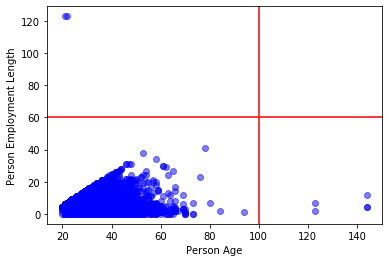

In [3]:
import matplotlib.pyplot as plt

# Study scatter of person_age and person_emp_length because it may contain identifiable outliers
plt.scatter(data['person_age'], data['person_emp_length'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Person Employment Length")

# It is highly unlikely that a borrower has work experience above 60 years or age above 100 years. Hence, observations
# with values above these will be considered outliers
plt.axvline(x=100, color='red')
plt.axhline(y=60, color='red')
plt.show()

In [5]:
# Remove obvious outliers: max_age=100, max_emp_length=60
max_age=100
max_emp_length=60
indices=data.query('person_age>{} or person_emp_length>{}'.format(max_age, max_emp_length)).index.tolist()
data_clean = data.drop(indices)
print ('Dataset free from obvious outliers')
print('')
print (descriptive(data_clean))
print('')

Dataset free from obvious outliers

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  32574        0     27.7     26.0    20.0        94.0
person_income                 int64  32574        0 65,878.5 55,000.0 4,000.0 2,039,784.0
person_home_ownership        object  32574        0                                      
person_emp_length           float64  31679      895      4.8      4.0     0.0        41.0
loan_intent                  object  32574        0                                      
loan_grade                   object  32574        0                                      
loan_amnt                     int64  32574        0  9,588.0  8,000.0   500.0    35,000.0
loan_int_rate               float64  29459     3115     11.0     11.0     5.4        23.2
loan_status                   int64  32574        0      0.2      0.0     0.0         1.0
loan_percent_income         float64  32574        0      0.2    

In [7]:
# Remove rows with missing interest rate data
indices=data_clean[data_clean['loan_int_rate'].isnull()].index
data_clean = data_clean.drop(indices)

# Replace missing data on employment length with median values
data_clean['person_emp_length']\
.fillna((data_clean['person_emp_length'].median()),inplace=True)

print ('Dataset free from obvious outliers and missing values')
print('')
print (descriptive(data_clean))
print('')

Dataset free from obvious outliers and missing values

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  29459        0     27.7     26.0    20.0        84.0
person_income                 int64  29459        0 65,803.7 55,000.0 4,000.0 2,039,784.0
person_home_ownership        object  29459        0                                      
person_emp_length           float64  29459        0      4.8      4.0     0.0        41.0
loan_intent                  object  29459        0                                      
loan_grade                   object  29459        0                                      
loan_amnt                     int64  29459        0  9,583.6  8,000.0   500.0    35,000.0
loan_int_rate               float64  29459        0     11.0     11.0     5.4        23.2
loan_status                   int64  29459        0      0.2      0.0     0.0         1.0
loan_percent_income         float64  29459   

In [9]:
#use one-hot encoding to create dummy variables based on object data
from logregression import dummied_data #this fuction recodes object variables into dummies
print(descriptive(dummied_data(data_clean)))

                                   Type      N  Missing      Avg      Med     Min         Max
person_age                        int64  29459        0     27.7     26.0    20.0        84.0
person_income                     int64  29459        0 65,803.7 55,000.0 4,000.0 2,039,784.0
person_emp_length               float64  29459        0      4.8      4.0     0.0        41.0
loan_amnt                         int64  29459        0  9,583.6  8,000.0   500.0    35,000.0
loan_int_rate                   float64  29459        0     11.0     11.0     5.4        23.2
loan_status                       int64  29459        0      0.2      0.0     0.0         1.0
loan_percent_income             float64  29459        0      0.2      0.1     0.0         0.8
cb_person_cred_hist_length        int64  29459        0      5.8      4.0     2.0        30.0
person_home_ownership_MORTGAGE    uint8  29459        0      0.4      0.0     0.0         1.0
person_home_ownership_OTHER       uint8  29459        0     

[[to top]](#top)<br>

## Model Run <a class="anchor" id="model-run"></a>
Now data looks ok. 
Let us start training logistic regression.
We start with dividing clean data set on train and test data in 3:2 proportion with split seed=121 and using 'loan_status' as a target variable.

In [10]:
from data_cleanup import split_data
X_train, X_test, y_train, y_test=split_data(dummied_data(data_clean), 'loan_status')
print('Training set:')
print('Size = {}'.format(y_train['loan_status'].count()))
print('Default ratio = {:.2f}'.format(y_train['loan_status'].mean()))
print('')
print('Test set:')
print('Size = {}'.format(y_test['loan_status'].count()))
print('Default ratio = {:.2f}'.format(y_test['loan_status'].mean()))

Training set:
Size = 17675
Default ratio = 0.22

Test set:
Size = 11784
Default ratio = 0.22


Training and test sets seem fair sized and provide identical default ratio.
Let us run the model on the training set, predict default values and study classification report using 0.4 threshold

In [11]:
from logregression import log_df_model #this function runs logistical regression on the data
from logregression import predict #this function predicts default outcome based on model and threshold 
from logregression import class_rep #this function returns classfication report

# Run default logistic default model on train data
ldm=log_df_model(X_train, y_train)  
      
#Run prediction based on the model
threshold=0.4
preds_df=predict(ldm,X_test,threshold) 

[[to top]](#top)

## Model Results and Graphs <a class="anchor" id="results"></a>

In [12]:
# Print the classification report
print('Threshold={}'.format(threshold))
print(class_rep(preds_df, y_test))

#Calculate accuracy of the model
print('Mean accuracy score is {:.4f}'.format(ldm.score(X_test,y_test)))

Threshold=0.4
              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9229
     Default       0.62      0.45      0.52      2555

    accuracy                           0.82     11784
   macro avg       0.74      0.69      0.71     11784
weighted avg       0.81      0.82      0.81     11784

Mean accuracy score is 0.8043


AUROC is one of the important measures of default model performance. AUROC close to 1 indicate perfect fit. AUROC close to 0 indicate the model is as good as guessing

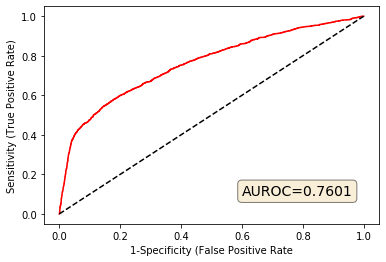

AUROC score is 0.7601


In [13]:
from logregression import roc_auroc #this function draws ROC curve and returns AUROC value

# Draw ROC curve
print('AUROC score is {:.4f}'. format(roc_auroc(preds_df['prob_default'],y_test)))

AUROC score of 0.76 is not great, but is not disasterous. Classification report, however, indicate the main problem of this model: low Default recall of 0.45. In other word, under threshold of 0.4 the model correctly predicts 0.92 non-defaults, but only 0.45 defaults.

Generally, there is a tradeoff between non-default and default recall and lowering threshold will improve the latter, but deteriorate the former.

Let us investigate the tradeoff between these two and accuracy dependence on the threshold.

In [34]:
from sklearn.metrics import precision_recall_fscore_support

trsh=[]
acc=[]
df_recall=[]
ndf_recall=[]
eq_i=-1 

for i in range(100,0,-1):
    trsh.append(i/100) 
    loan_status = preds_df['prob_default'].apply(lambda x: 1 if x > i/100 else 0)
    scores=precision_recall_fscore_support(y_test,loan_status)
    df_recall.append(scores[1][1])
    ndf_recall.append(scores[1][0])
    acc.append((scores[1][1]*scores[3][1]+scores[1][0]*scores[3][0])/(scores[3][0]+scores[3][1]))
    # check if ndf crosses df
    if eq_i==-1 and ndf_recall[-1]<df_recall[-1]: eq_i=i
print(len(trsh))

100


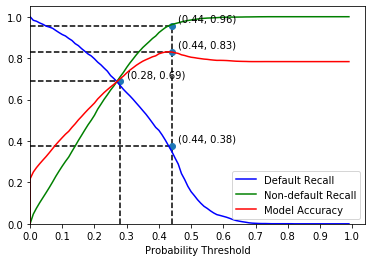

In [38]:
from sklearn.metrics import precision_recall_fscore_support

trsh=[0]
acc=[0]
df_recall=[1]
ndf_recall=[0]
eq_i=-1 #Stores point of intersect of DF and NDF Recall curves

for i in range(0,100):
    trsh.append(i/100) 
    loan_status = preds_df['prob_default'].apply(lambda x: 1 if x > i/100 else 0)
    scores=precision_recall_fscore_support(y_test,loan_status)
    df_recall.append(scores[1][1])
    ndf_recall.append(scores[1][0])
    acc.append((scores[1][1]*scores[3][1]+scores[1][0]*scores[3][0])/(scores[3][0]+scores[3][1]))
    # check if ndf crosses df
    if eq_i==-1 and ndf_recall[i]>df_recall[i]: eq_i=i
        
max_acc_i=np.argmax(acc)
ticks=np.linspace(0,1,11).tolist()
plt.plot(trsh,df_recall,color='blue')
plt.plot(trsh,ndf_recall,color='green')
plt.plot(trsh,acc,color='red')
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])

x = [eq_i/100,max_acc_i/100,max_acc_i/100,max_acc_i/100]
y = [acc[eq_i],acc[max_acc_i], df_recall[max_acc_i],ndf_recall[max_acc_i]]

plt.vlines(x[0:2], 0, [y[0], max(y)], linestyle="dashed")
plt.hlines(y, 0, x, linestyle="dashed")
plt.scatter(x, y, zorder=2)

plt.xlim(0,None)
plt.ylim(0,None)

for i_x, i_y in zip(x, y):
    plt.text(i_x+0.02, i_y+0.02, '({:.2f}, {:.2f})'.format(i_x, i_y))

plt.show()

Default recall is equal to nondefault recall when threshold is 0.27.
This poses two problems: 
1. the 'equilibrium' recall of 0.69 is quite low. The model will fail to predict 31% of defaults correctly. This may lead to substantiall losses (which we will address below)
2. the 'equilibrium' threshold of 0.27 is very low. It suggests that the loan application should be considered as a high-risk if probability of default is 27%.

Note that accuracy is maxed at threshold value of 0.43. But chosing this threshold results in a very low default recall of 0.38, which possibly makes this point not an obvious candidate for the modelling.<br>
[[to top]](#top)

## Business Case <a class="anchor" id="business-case"></a>
Let us use model with a threshold of 0.27 on a test set and run a simple cost-benefit analysis. Since loan duration data is not available in the sample, let us assume that all loans have maturity of 10 years. Assume also that the future discounts at 2%

First let us calculate gains and losses from doing nothing As such, assume that all non-default loans in the test sample will be ammortized equally over 10 years and a corresponding interest will be paid on the outstanding amount. Assume further that all defaulted loans in the test sample default immediately and no debt is recovered.

In [13]:
X_test1=X_test.reset_index()
y_test1=y_test.reset_index()
data_test=pd.concat([X_test1,y_test1],axis=1)

def revenue(amt, loan_int):
    revenue=0
    for i in range(10):
        revenue+=(1-i/10)*amt*loan_int*0.01/(1.02**i)
    return(revenue)

data_test['revenue']=-data_test['loan_amnt']*data_test['loan_status']\
+(1-data_test['loan_status'])*revenue(data_test['loan_amnt'], data_test['loan_int_rate'])

print('Expected net profit without model-induced decision-making is {:.1f}M'
      .format(0.000001*data_test['revenue'].sum()))

Expected net profit without model-induced decision-making is 19.7M


Hence, if a predictive model is not used, a firm wil make 19.6M profit if it approves all the loans.

Suppose we apply model based on the threshold of 0.27.
There are three possible outcomes depicted by the following tree:

Loan is approved? YES Creditor defaults? YES Loan amount is lost<br>
Loan is approved? YES Creditor defaults? NO Interest revenue received<br>
Loan is approved? NO Zero revenue is received<br>
                    
Loan is approved if no default is expected (predicted probability of default is less that threshold) and is rejected otherwise.
Creditor defaults if true 'loan_status' is 1 and does not default otherwise.

Let us model this on the test data

In [14]:
threshold=0.27

def pred_net_profit (model, X_tst, thrsh, revenue):
    preds_df=predict(model,X_tst,thrsh) 
    df=pd.concat([revenue, preds_df['loan_status']],axis=1)
    return (0.000001*((1-preds_df['loan_status'])*revenue).sum())

print('Expected net profit with non-optimized model-induced decision-making is {:.1f}M'
      .format(pred_net_profit(ldm, X_test, threshold, data_test['revenue'])))


Expected net profit without model-induced decision-making is 24.4M


Even on a model with as low default/nondefault recall of 0.69, a firm will increase its profit by almost 25%.

One may wonder what would be a threshold level that maximizes profit. 
An important reservation exists here.
This will depend on the future data, which may or may not have the same data structure as train data. Using test data to predict future performance is not, therefore, justified.

We may investigate, however, what is the threshold level that maximizes profit on test data.

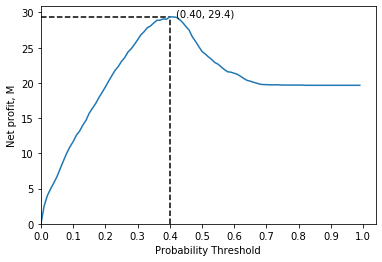

Maximum net profit of 29.4M on test set is achieved when using threshold value of 0.40


In [15]:
trsh=[]
net_prof=[]
for i in range(0,100): 
    net_prof.append(pred_net_profit(ldm, X_test, i/100, data_test['revenue']))
    trsh.append(i/100)
    
max_np_i=np.argmax(net_prof)

ticks=np.linspace(0,1,11).tolist()
plt.plot(trsh,net_prof)
x=max_np_i/100
y=net_prof[max_np_i]
plt.vlines(x, 0, y, linestyle="dashed")
plt.hlines(y, 0, x, linestyle="dashed")
plt.xlabel("Probability Threshold")
plt.ylabel("Net profit, M")
plt.xticks(ticks)
plt.text(x+0.02, y+0.02, '({:.2f}, {:.1f})'.format(x, y))
plt.xlim(0,None)
plt.ylim(0,None)

plt.show()

print('Maximum net profit of {:.1f}M on test set is achieved when using threshold value of {:.2f}'
      .format(net_prof[max_np_i],max_np_i/100))


Interestingly, a threshold value maximizing net profits (0.4) is very close to the threshold value maximizing accuracy (0.43).

When used on the test data, model-induced decision making may increase net profit from loans by 50%  (from 19.6 to 29.4M) as compared to current decision-making guidelines (which is an equivalent of using threshold value 1.0).
Note that a non-conservative approach that uses threshold value above approximately 0.7 will be as good (as bad?) as a current decision-making approach.

The exact order of magintude however is sensitive to the assumptions on the duration of the non-defaulting loans which we assumed equal to 10 years uniformely.

[[to top]](#top)